# Using the rate to correct timestamp

Well here is another dead attempt to correct for the timestamp. This time we will use the aggregate data from the orbit buffer to bring back the pps. We will do a test drive on the veto pack

In [1]:
# Import libraries
import raadpy as rp
import matplotlib.pyplot as plt
import numpy as np

# Some constants
orbit_buffer_fname  = '../../Data/RAW/SD-1015/light1-SD-1015-buff1.dat'
nveto_buffer_fname  = '../../Data/RAW/SD-1015/light1-SD-1015-buff5.dat'

%matplotlib ipympl

In [2]:
# Load the buffers
orbit   = rp.get_dict(orbit_buffer_fname,rp.ORBIT_STRUCT,condition="data['id_bit'] == 0")
nveto   = rp.get_dict(nveto_buffer_fname,rp.NONVETO_STRUCT,MAX=None,STUPID=True)

Line:   0%|          | 0/392 [00:00<?, ?it/s]

Line:   0%|          | 0/208563 [00:00<?, ?it/s]

In [3]:
# Get only channel 0
nveto = rp.split_channels(nveto,rp.NONVETO_STRUCT)[0]

(<Figure size 1500x400 with 1 Axes>,
 <AxesSubplot:title={'center':'Timestamps vs event number'}>)

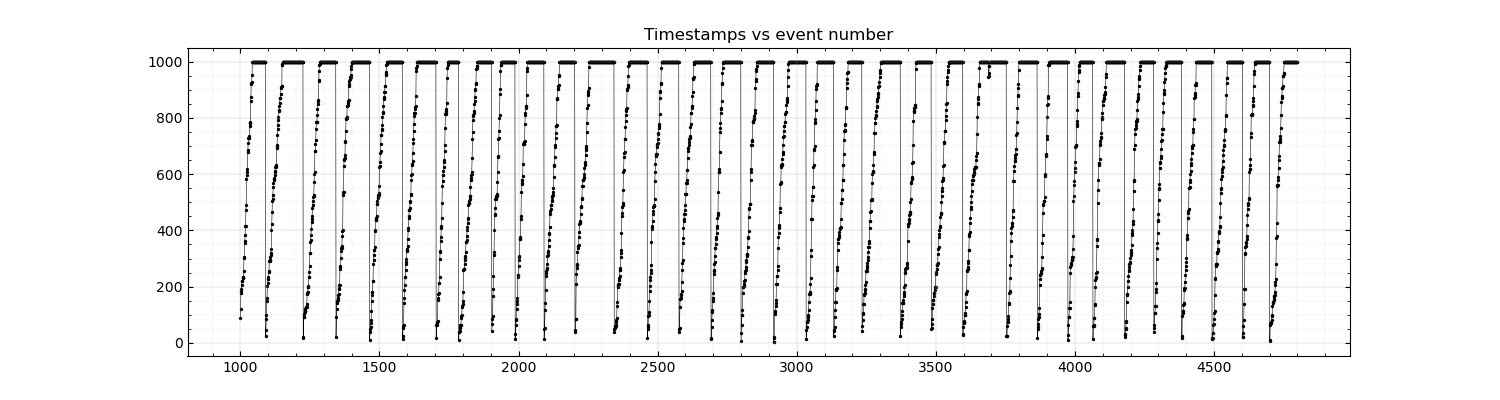

In [4]:
# Here is Some timestamps
rp.plot_timestamp(nveto,RANGE=(1000,4800))

Text(0.5, 0, 'seconds')

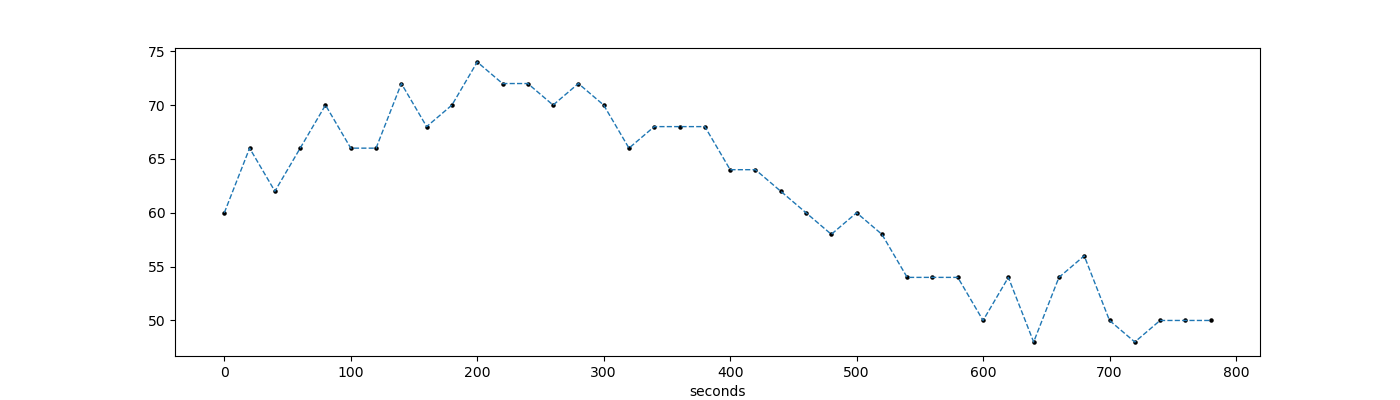

In [5]:
# Here are some rates
RANGE   = (0,40)
NUM     = RANGE[1]-RANGE[0]

fig = plt.figure(figsize=(14,4),dpi=100)
ax  = fig.add_subplot(111)
x   = np.arange(NUM)*20
ax.plot(x,orbit['rate0'][RANGE[0]:RANGE[1]],ls='--',lw=1)
ax.scatter(x,orbit['rate0'][RANGE[0]:RANGE[1]],marker='o',s=5,c='k')
ax.set_xlabel('seconds')

Text(0.5, 0, 'seconds')

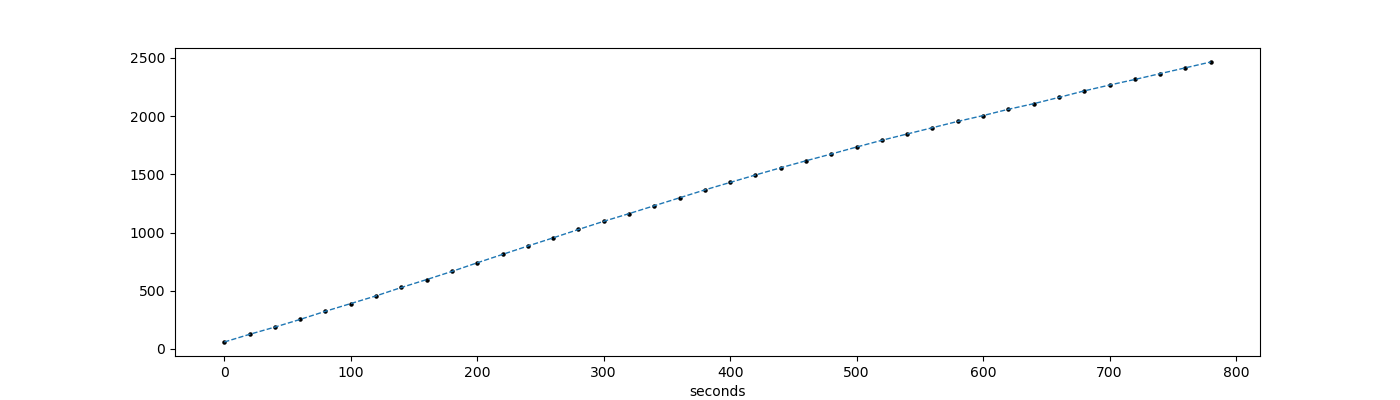

In [6]:
# Let's sum those rates
RANGE   = (0,40)
NUM     = RANGE[1]-RANGE[0]

fig = plt.figure(figsize=(14,4),dpi=100)
ax  = fig.add_subplot(111)
x   = np.arange(NUM)*20
ax.plot(x,np.cumsum(orbit['rate0'][RANGE[0]:RANGE[1]]),ls='--',lw=1)
ax.scatter(x,np.cumsum(orbit['rate0'][RANGE[0]:RANGE[1]]),marker='o',s=5,c='k')
ax.set_xlabel('seconds')

In [8]:
# Now let's get some counts!
TIME    = 20
RANGE   = (0,40)
timestamp,start_cnt,end_cnt = rp.correct_time_orbit(orbit,key='rate0',TIME=TIME,RANGE=RANGE)

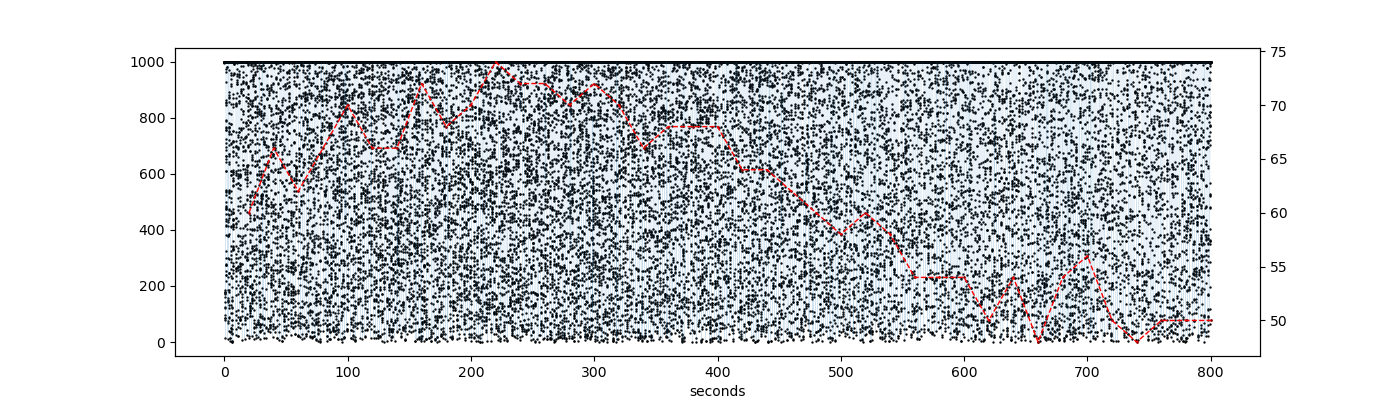

In [9]:
# Let's sum those rates
fig = plt.figure(figsize=(14,4),dpi=100)
ax  = fig.add_subplot(111)
ax2 = ax.twinx()
ax.set_xlabel('seconds')
ax.plot(timestamp,nveto['stimestamp'][start_cnt:end_cnt],ls='--',lw=.1)
ax.scatter(timestamp,nveto['stimestamp'][start_cnt:end_cnt],marker='o',s=.5,c='k')
ax2.plot(np.arange(RANGE[1]-RANGE[0])*TIME + TIME,orbit['rate0'][RANGE[0]:RANGE[1]],ls='--',lw=1,c='r')
ax2.scatter(np.arange(RANGE[1]-RANGE[0])*TIME + TIME,orbit['rate0'][RANGE[0]:RANGE[1]],marker='o',s=1,c='darkred')

(<Figure size 1500x400 with 1 Axes>,
 <AxesSubplot:title={'center':'Timestamps vs event number'}>)

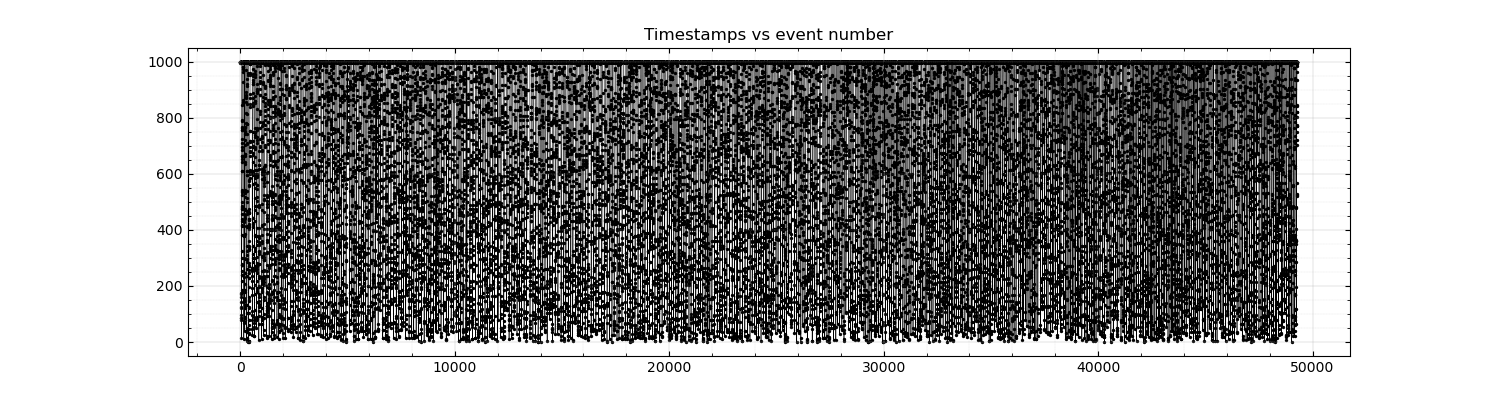

In [10]:
# Here is Some timestamps
rp.plot_timestamp(nveto,RANGE=(start_cnt,end_cnt))

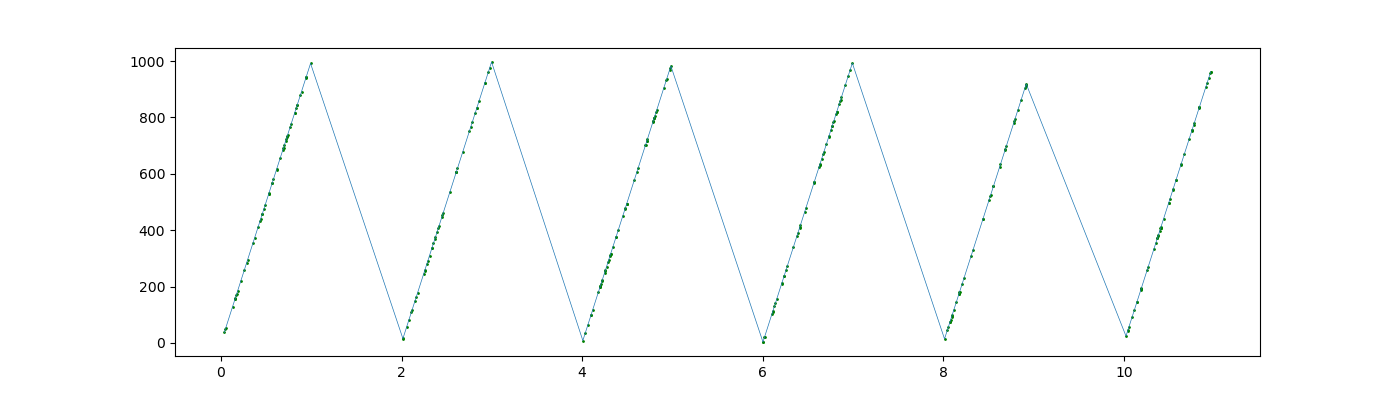

In [11]:
# To auditionally correct for the rest of the data we want to so using the stimestamp

# Apply this to the data
# Assume the parameters of the stimestamp saturation are as follows
RIZE_TIME   = 1         # In seconds 
CONST_TIME  = 1         # In seconds
TMAX        = 1000-1   # Maximum number of ticks per second
RANGE       = (2560, 3280)  # Range of timestamps to look at

timestamp_FPGA,valid_data,ramps = rp.correct_time_FPGA(nveto,RIZE_TIME=RIZE_TIME,CONST_TIME=CONST_TIME,TMAX=TMAX,RANGE=RANGE,return_endpoints=True)

fig = plt.figure(figsize=(14,4),dpi=100)
ax  = fig.add_subplot(111)
ax.plot(timestamp_FPGA,nveto['stimestamp'][valid_data],lw=0.5)
ax.scatter(timestamp_FPGA,nveto['stimestamp'][valid_data],c='g',s=1)
# ax.scatter(ending,veto['stimestamp'][ending],c='r',s=1)


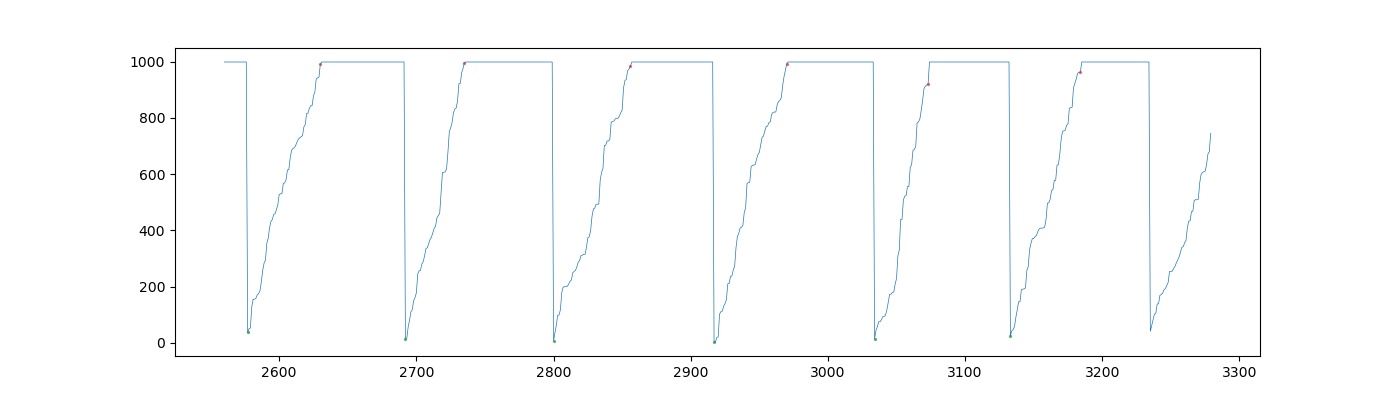

In [12]:
starting = ramps.T[0]
ending = ramps.T[1]
fig = plt.figure(figsize=(14,4),dpi=100)
ax  = fig.add_subplot(111)
ax.plot(range(*RANGE),nveto['stimestamp'][RANGE[0]:RANGE[1]],lw=0.5)
ax.scatter(starting,nveto['stimestamp'][starting],c='g',s=2,alpha=0.5)
ax.scatter(ending,nveto['stimestamp'][ending],c='r',s=2,alpha=0.5)

In [18]:
# Now putting everything together
TIME        = 20
RANGE       = (0,40)
RIZE_TIME   = .99      # In seconds 
CONST_TIME  = 1.0      # In seconds
TMAX        = 1000-1   # Maximum number of ticks per second

# Obtain the corrections
timestamp, total_cnt, valid_events = rp.correct_time(nveto,orbit,key='rate0',TIME=TIME,RANGE_ORBIT=RANGE,RIZE_TIME=RIZE_TIME,CONST_TIME=CONST_TIME,TMAX=TMAX)


Oops':  1.0


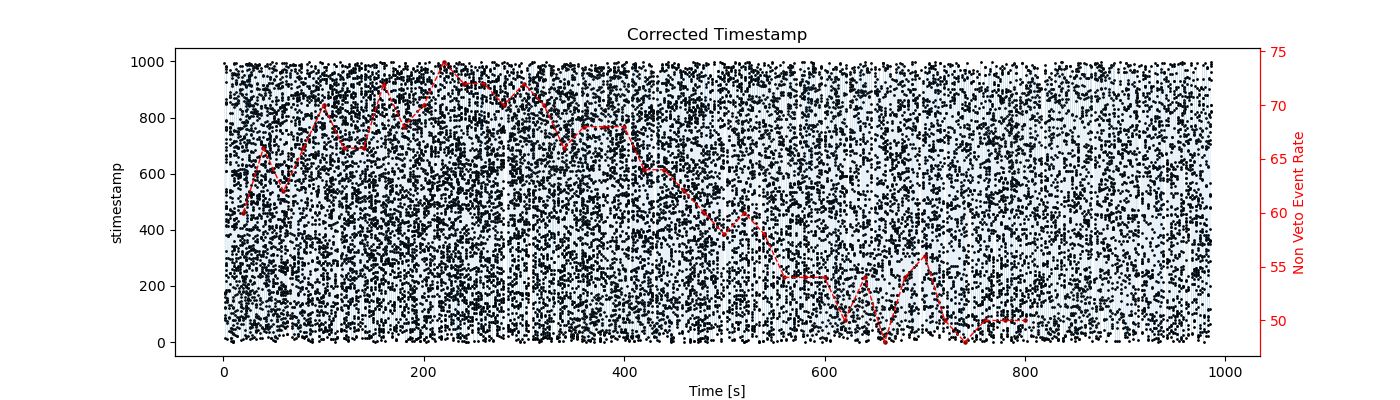

In [19]:
fig = plt.figure(figsize=(14,4),dpi=100)
ax  = fig.add_subplot(111)
ax2 = ax.twinx()
ax.plot(timestamp,nveto['stimestamp'][valid_events],lw=0.1,ls='--')
ax.scatter(timestamp,nveto['stimestamp'][valid_events],c='k',s=1)
# ax.scatter(ending,nveto['stimestamp'][ending],c='r',s=1)
ax2.plot(np.arange(*RANGE)*TIME + TIME,orbit['rate0'][RANGE[0]:RANGE[1]],ls='--',lw=1,c='r')
ax2.scatter(np.arange(*RANGE)*TIME + TIME,orbit['rate0'][RANGE[0]:RANGE[1]],marker='o',s=5,c='darkred')
ax.set_xlabel('Time [s]')
ax.set_ylabel('stimestamp')
ax.set_title('Corrected Timestamp')
ax2.set_ylabel('Non Veto Event Rate',c='r')
ax2.spines['right'].set_color('r')
ax2.tick_params(axis='y', colors='r')

Text(0.5, 1.0, 'Event Number VS Timestamp')

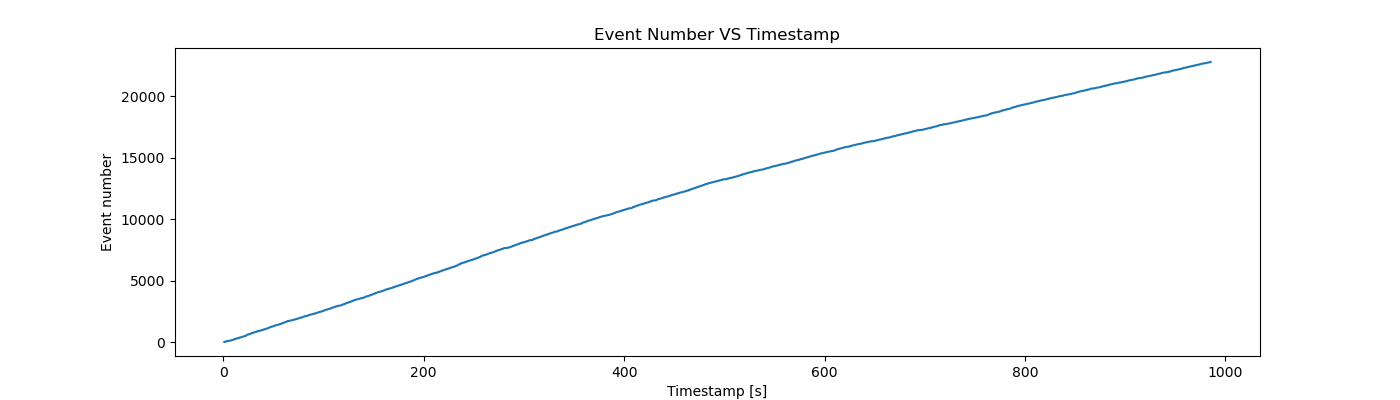

In [17]:
fig = plt.figure(figsize=(14,4),dpi=100)
ax  = fig.add_subplot(111)
ax.plot(timestamp,list(range(len(timestamp))))
ax.set_xlabel('Timestamp [s]')
ax.set_ylabel('Event number')
ax.set_title('Event Number VS Timestamp')